In [ ]:
!gpustat

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator



from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [184]:
def MLP(layers, activation, off_set = 1., b_init = 0.):
    '''
    Vanilla MLP with fan_in initialization
    '''
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = off_set / np.sqrt(d_in)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = b_init * np.ones(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = inputs@W + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = inputs@W + b
        return outputs
    return init, apply

def hidden_output(params, X, activation):
    '''
    Compute a list of outputs for each layer of MLP.
    params should be organized as ((w,b),...)
    '''
    inputs = X
    for W, b in params[:-1]:
        outputs = inputs@W + b
        inputs = activation(outputs)
        yield inputs
    W, b = params[-1]
    yield inputs@W + b

def init_net(params, activation):
    '''
    return output with fixed matrix directions but trainable scale and bias.
    '''
    def init(key):
        p_list = []
        keys = random.split(key)
        for (w, b) in params:
            
            init_w = np.exp(0.25 * random.normal(keys[0]))
            init_b = 0.1 * random.normal(keys[1])
            p_list.append((init_w, init_b))
            
            keys = random.split(keys[0])
        return p_list
    def apply(p_list, X):
        inputs = X
        
        for (w, b), (w_init, b_init) in zip(params[:-1], p_list[:-1]):
            outputs = w_init * (inputs @ w) + b + b_init
            inputs = activation(outputs)
        
        w, b = params[-1]
        w_init, b_init = p_list[-1]
        
        return w_init * (inputs @ w) + b + b_init
    return init, apply

def parameter_scaling(params, scale_params):
    return [(w * w_init, b + b_init)for (w, b), (w_init, b_init) in zip(params, scale_params)]

class initNet:
    def __init__(self, layers, activation, key = random.PRNGKey(0)):
        
        self.activation = activation
        self.layers = layers
        self.key = key
        self.net_init, self.net_apply = MLP(self.layers, self.activation)
        self.net_params = self.net_init(self.key)
        
        self.key, _ = random.split(self.key)
        
        self.scale_init, self.scale_apply = init_net(self.net_params, self.activation)
        self.scale_params = self.scale_init(self.key)
        
        self.key, _ = random.split(self.key)
    
    def update_net(self, net_params):
        self.scale_init, self.scale_apply = init_net(net_params, self.activation)
        
        
    def cosines(self, scale_params, X):
        out = self.scale_apply(scale_params ,X)
        out = out / np.linalg.norm(out, axis = 0)
        c = out.T @ out
        c = index_update(c,index[np.arange(self.layers[-1]), np.arange(self.layers[-1])], 0)
        return c + 1e-8
    
    def angles(self, scale_params, X):
        return np.degrees(np.arccos(np.abs(self.cosines(scale_params, X))))
    
    @partial(jit, static_argnums=(0,))
    def logSineLoss(self, scale_params, X):
        sines_square = 1 - self.cosines(scale_params, X)
        return -np.log(1e-4 + sines_square).mean()
    
    
    def plot_degree(self, scale_params, X, figsize = (5,4), word = True):
        
        plt.figure(figsize=figsize)

        degree = self.angles(scale_params, X)
        
        m = plt.matshow(degree, fignum = 1, vmin = 0, vmax = 90)
        if word:

            for (x, y), value in onp.ndenumerate(degree):
                plt.text(x, y, f"{value:.1f}", va="center", ha="center", color = 'r')
        c = plt.colorbar(m)
        plt.title(f"Angle between basis. Log sine loss: {self.logSineLoss(scale_params, X):.2e}")

        plt.show()
        plt.close()
    
    @partial(jit, static_argnums=(0,))
    def hidden_output(self, params, X):
        '''
        params should be organized as ((w,b),...)
        '''
        p_list = []
        
        inputs = X
        for W, b in params[:-1]:
            outputs = inputs@W + b
            inputs = self.activation(outputs)
            p_list.append(inputs)
        W, b = params[-1]
        p_list.append(inputs@W + b)
        return p_list

In [175]:
key = random.PRNGKey(int(time.time() * 100))

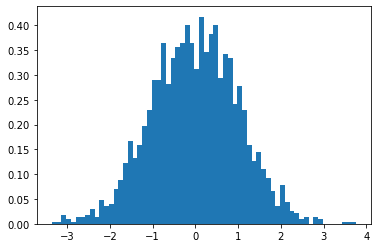

In [176]:
# X = random.uniform(key, shape = (2048, 1), minval = -np.sqrt(3), maxval = np.sqrt(3))
X = random.normal(key, shape = (2048, 1))
plt.figure()
h = plt.hist(X.flatten(), bins = 64, density = True)
plt.show()
plt.close()

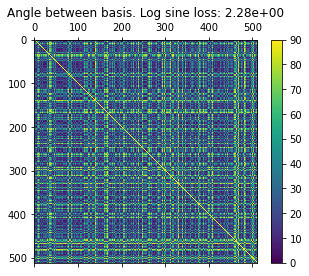

In [225]:
model = initNet([X.shape[1], *[512 for _ in range(9)]], activation = np.tanh)
model.plot_degree(model.scale_params, X, word = False)

In [226]:
lr = 1e-2
init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.1)

@jit
def step(i, state, X):
    g = grad(model.logSineLoss)(get_params(state), X)
    return update_fn(i, g, state)

In [227]:
opt_state = init_fn(model.scale_params)
nIter = 50000
pbar = trange(nIter)

for i in pbar:
    opt_state = step(i, opt_state, X)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': model.logSineLoss(get_params(opt_state), X)})


100%|██████████| 50000/50000 [01:07<00:00, 741.18it/s, Log sine loss=0.03271288] 


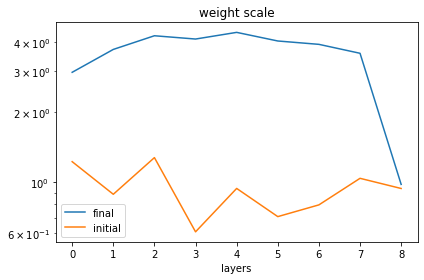

In [228]:
plt.figure()

plt.plot([w_init for w_init, b_init in params], label = 'final')
plt.plot([w_init for w_init, b_init in model.scale_params], label = 'initial')

plt.yscale('log')
plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

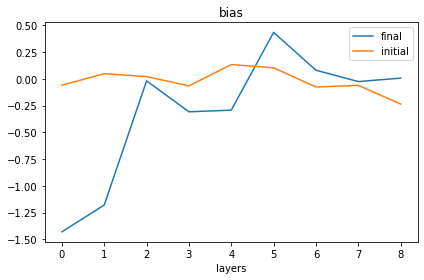

In [229]:
plt.figure()

plt.plot([b_init for w_init, b_init in params], label = 'final')
plt.plot([b_init for w_init, b_init in model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

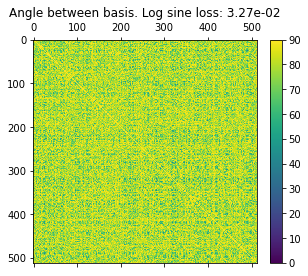

In [230]:
model.plot_degree(params, X, word = False)

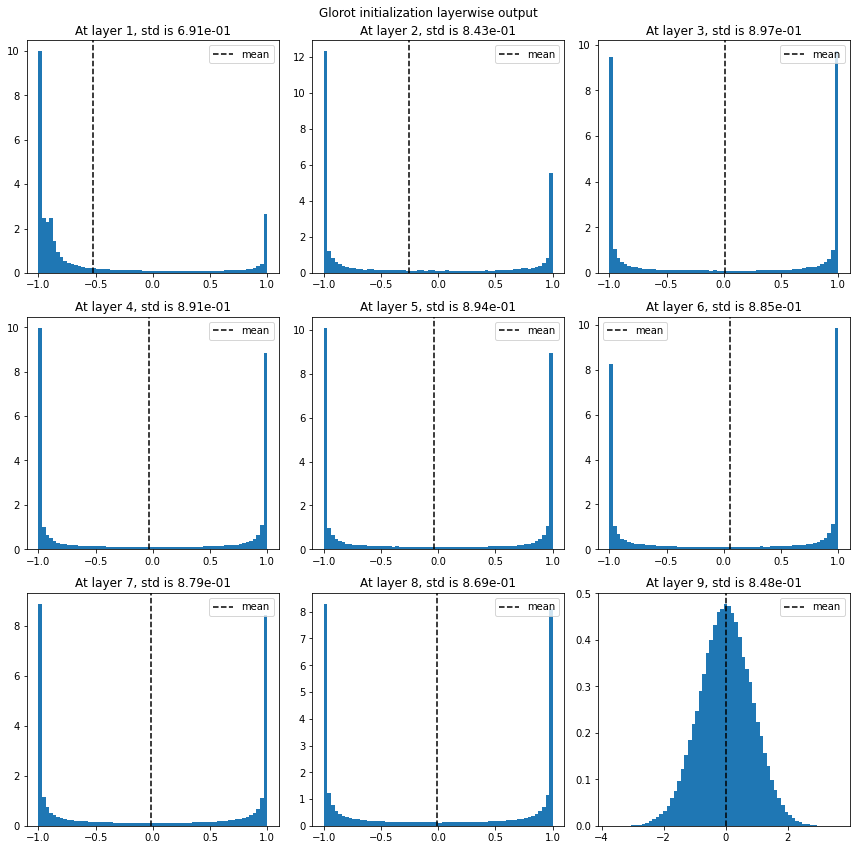

In [231]:
hidden_out = model.hidden_output(parameter_scaling(model.net_params, params), X)

plt.figure(figsize = (12,12))
for i, out in enumerate(hidden_out):
    plt.subplot(3,3,i + 1)
    plt.hist(out.flatten(), bins = 64, density = True)
    plt.axvline(out.flatten().mean(), linestyle= '--', color = 'k', label = 'mean')
    plt.title(f'At layer {int(i + 1)}, std is {out.flatten().std():.2e}')
    plt.legend()
    plt.tight_layout()

plt.suptitle(f'Glorot initialization layerwise output')
plt.tight_layout()
plt.show()
plt.close()


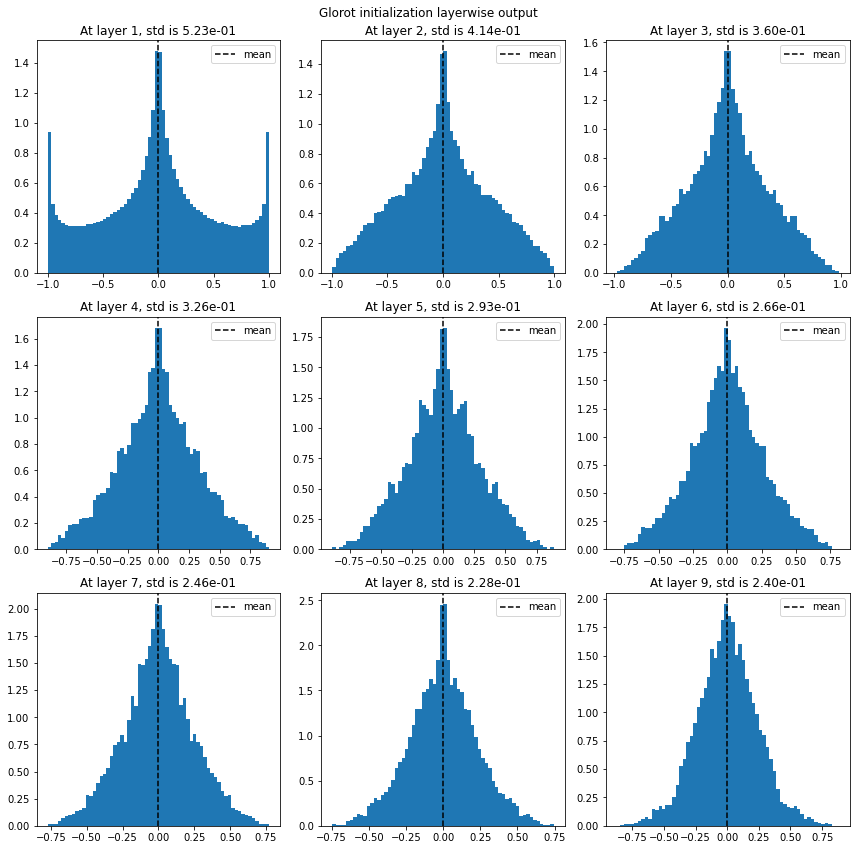

In [232]:
hidden_out = model.hidden_output(model.net_params, X)

plt.figure(figsize = (12,12))
for i, out in enumerate(hidden_out):
    plt.subplot(3,3,i + 1)
    plt.hist(out.flatten(), bins = 64, density = True)
    plt.axvline(out.flatten().mean(), linestyle= '--', color = 'k', label = 'mean')
    plt.title(f'At layer {int(i + 1)}, std is {out.flatten().std():.2e}')
    plt.legend()
    plt.tight_layout()

plt.suptitle(f'Glorot initialization layerwise output')
plt.tight_layout()
plt.show()
plt.close()